In [26]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import numpy as np

In [27]:
# matrice de similarité
sim_mat = np.array([
    [10, 6, 0, 0, 0, 0, 0, 0, 0],
    [6, 10, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 10, 5, 3, 3, 1, 1, 0],
    [0, 0, 5, 10, 1, 2, 1, 1, 0],
    [0, 0, 3, 1, 10, 4, 1, 2, 0],
    [0, 0, 3, 2, 4, 10, 1, 4, 0],
    [0, 0, 1, 1, 1, 1, 10, 1, 0],
    [0, 0, 1, 1, 2, 4, 1, 10, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 10]
])

labels = ["arabe", "hébreu", "sanskrit", "avestique", "grec classique", "latin", "gotique", "irlandais ancien", "turc"]

In [28]:
def first_algo():
    I = [True] * len(labels)  # Indicator for active clusters
    P = [[] for _ in range(len(labels))]  # Priority queues for each cluster
    L = []  # List to store the fusion steps

    # Initialize priority queues
    def init(sim_matrice, labels):
        for i in range(len(labels)):
            P[i] = sorted(range(len(sim_matrice[i])), key=lambda k: sim_matrice[i][k], reverse=True)[1:]
            print(f"File de priorité pour {labels[i]}: {P[i]}")

    init(sim_mat, labels)

    for _ in range(len(labels)-1):
        max_sim = -1
        i1, i2 = -1, -1
        for i in range(len(labels)):
            if I[i]:
                for j in range(len(labels)):
                    if I[j] and sim_mat[i][j] > max_sim and j != i:
                        max_sim = sim_mat[i][j]
                        i1, i2 = i, j

        # Merge clusters i1 and i2
        I[i2] = False
        L.append([i1, i2])
        
        print(f"Fusion de {labels[i1]} et {labels[i2]}")
        
        # Update the sim matrix
        for i in range(len(labels)):
            if I[i] and i != i1:
                sim_mat[i][i1] = sim_mat[i1][i] = max(sim_mat[i][i1], sim_mat[i][i2])  # Single-linkage: max(sim(di, d1), sim(di, d2))

        # Remove i2
        for i in range(len(labels)):
            if I[i] and i != i1:
                if i2 in P[i]:
                    P[i].remove(i2)
                if i1 in P[i]:
                    P[i].remove(i1)
        
        # Update i1
        P[i1] = sorted([i for i in range(len(labels)) if I[i] and i != i1], key=lambda x: sim_mat[i1][x], reverse=True)
    print("Liste des fusions effectuées:", L)
    return L

def second_algo():
    # Priority queues and active cluster indices
    I = list(range(len(labels)))  # Initially, each document is its own cluster
    P = [[0, -1] for _ in range(len(labels))]  # (similarity, index of the most similar cluster)
    L = []  # List of fusions

    # Initialize the closest document for each document
    def init(sim_matrice, labels):
        for i in range(len(labels)):
            for j in range(len(labels)):
                if i != j and P[i][0] < sim_matrice[i][j]:
                    P[i] = [sim_matrice[i][j], j]
            print(f"Document le plus proche de {labels[i]} est {labels[P[i][1]]} avec une similarité de {P[i][0]}")

    # Perform initialization
    init(sim_mat, labels)

    # Iterative merging process
    for _ in range(len(labels) - 1):
        # Find the pair of clusters with the highest similarity
        i1 = max([i for i in range(len(labels)) if I[i] == i], key=lambda x: P[x][0])
        i2 = I[P[i1][1]]
        P[i1][0] = -1  # Reset
        
        # Merge clusters i1 and i2
        L.append([i1, i2])
        print(f"Fusion de {labels[i1]} et {labels[i2]}")
        
        # Update similarity matrix for the new merged cluster i1
        for i in range(len(labels)):
            if I[i] == i and i != i1 and i != i2:
                sim_mat[i][i1] = sim_mat[i1][i] = max(sim_mat[i][i1], sim_mat[i][i2])  # Single-linkage update
            if I[i] == i2:
                I[i] = i1
            if I[i] == i and i != i1 and sim_mat[i1][i] > P[i1][0]:
                P[i1] = [sim_mat[i1][i], i]
        
    print("Liste des fusions effectuées:", L)
    return L


In [29]:
def create_linkage_matrix(L, n):
    Z = np.zeros((n - 1, 4)) #initalize empty linkage matrix
    current_cluster = np.arange(n)
    cluster_sizes = np.ones(n)
    next_cluster_index = n

    #linkage matrix construction
    for k, (i1, i2) in enumerate(L):
        ci1, ci2 = current_cluster[i1], current_cluster[i2] #get the current active cluster of a language 
        Z[k] = [ci1, ci2, k + 1, cluster_sizes[ci1] + cluster_sizes[ci2]] # [idx1, idx2, distance, n_elements]
        current_cluster[i1] = current_cluster[i2] = next_cluster_index #update active clusters
        cluster_sizes = np.append(cluster_sizes, Z[k, 3]) #update the cluster size after merge
        next_cluster_index += 1

    return Z

def plot_dendrogram(Z, labels):
    fig, ax = plt.subplots(figsize=(10, 5))
    n = len(labels)
    x_coords = {i: i for i in range(n)}
    y_coords = {i: 0 for i in range(n)}

    for i, (ci1, ci2, dist, _) in enumerate(Z):
        x1, x2 = x_coords[ci1], x_coords[ci2]
        y1, y2 = y_coords[ci1], y_coords[ci2]
        x_new = (x1 + x2) / 2
        y_new = dist

        ax.plot([x1, x1, x2, x2], [y1, y_new, y_new, y2], c='b')
        ax.plot([x1, x2], [y_new, y_new], c='b')

        x_coords[n + i] = x_new
        y_coords[n + i] = y_new

    ax.set_xticks(range(n))
    ax.set_xticklabels(labels)
    ax.set_xlabel('Languages')
    ax.set_ylabel('Distance')
    ax.set_title('Dendrogram of Language Clustering')
    plt.show()

# Affichage des dendogrammes pour les deux algo

File de priorité pour arabe: [1, 2, 3, 4, 5, 6, 7, 8]
File de priorité pour hébreu: [0, 2, 3, 4, 5, 6, 7, 8]
File de priorité pour sanskrit: [3, 4, 5, 6, 7, 0, 1, 8]
File de priorité pour avestique: [2, 5, 4, 6, 7, 0, 1, 8]
File de priorité pour grec classique: [5, 2, 7, 3, 6, 0, 1, 8]
File de priorité pour latin: [4, 7, 2, 3, 6, 0, 1, 8]
File de priorité pour gotique: [2, 3, 4, 5, 7, 0, 1, 8]
File de priorité pour irlandais ancien: [5, 4, 2, 3, 6, 0, 1, 8]
File de priorité pour turc: [0, 1, 2, 3, 4, 5, 6, 7]
Fusion de arabe et hébreu
Fusion de sanskrit et avestique
Fusion de grec classique et latin
Fusion de grec classique et irlandais ancien
Fusion de sanskrit et grec classique
Fusion de sanskrit et gotique
Fusion de arabe et sanskrit
Fusion de arabe et turc
Liste des fusions effectuées: [[0, 1], [2, 3], [4, 5], [4, 7], [2, 4], [2, 6], [0, 2], [0, 8]]


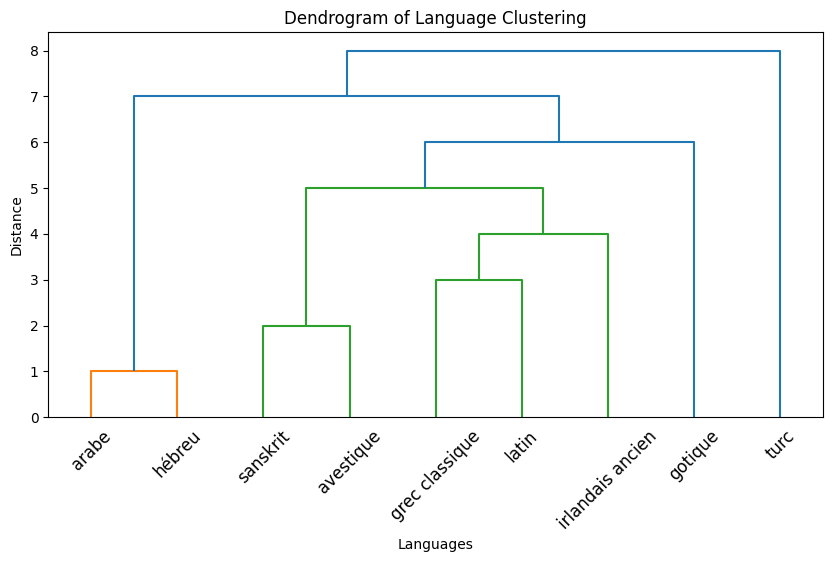

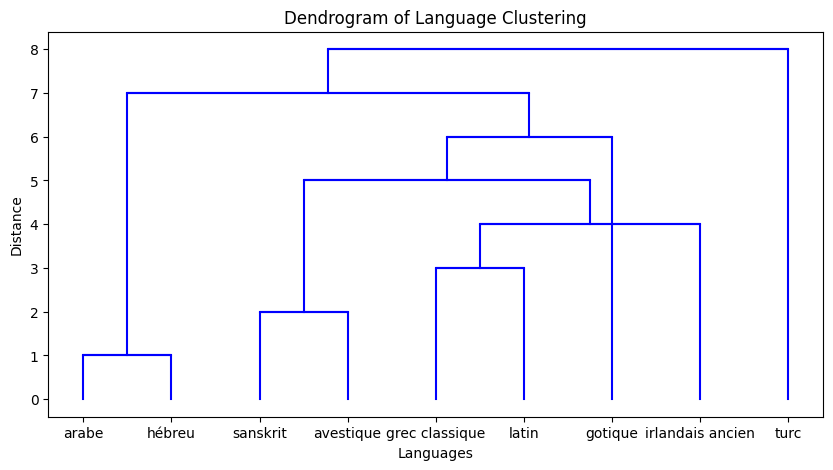

Document le plus proche de arabe est hébreu avec une similarité de 6
Document le plus proche de hébreu est arabe avec une similarité de 6
Document le plus proche de sanskrit est avestique avec une similarité de 5
Document le plus proche de avestique est sanskrit avec une similarité de 5
Document le plus proche de grec classique est latin avec une similarité de 4
Document le plus proche de latin est grec classique avec une similarité de 4
Document le plus proche de gotique est sanskrit avec une similarité de 1
Document le plus proche de irlandais ancien est grec classique avec une similarité de 4
Document le plus proche de turc est turc avec une similarité de 0
Fusion de arabe et hébreu
Fusion de sanskrit et avestique
Fusion de grec classique et latin
Fusion de grec classique et irlandais ancien
Fusion de sanskrit et grec classique
Fusion de sanskrit et gotique
Fusion de arabe et sanskrit
Fusion de arabe et turc
Liste des fusions effectuées: [[0, 1], [2, 3], [4, 5], [4, 7], [2, 4], [2, 

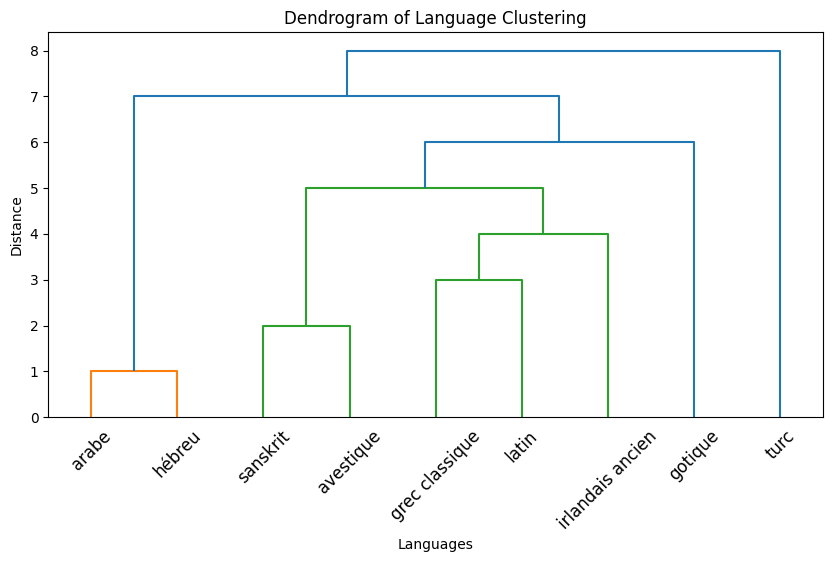

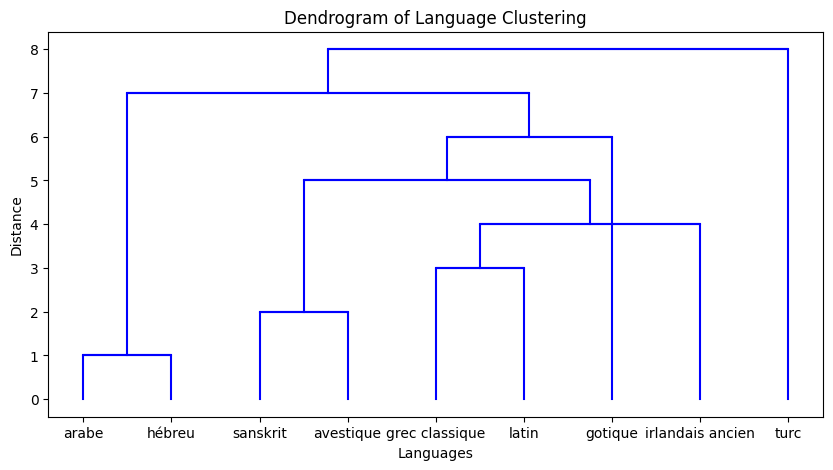

In [30]:
# First algorithm
L = first_algo()
Z = create_linkage_matrix(L, len(labels))

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=labels)
plt.title('Dendrogram of Language Clustering')
plt.xlabel('Languages')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.show()

# Plot the dendrogram
plot_dendrogram(Z, labels)

# Second algorithm
L = second_algo()
Z = create_linkage_matrix(L, len(labels))

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=labels)
plt.title('Dendrogram of Language Clustering')
plt.xlabel('Languages')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.show()

# Plot the dendrogram
plot_dendrogram(Z, labels)

# Complexité de l'algo 1 par rapport à l'algo 2 :
L'algo 1 a une complexité de O(n³) tant dit que l'algo 2 a une complexité de O(n²).
L'algo 2 est donc plus interessant.